In [24]:
import cs_vqe_classes.cs_vqe_circuit as cs_circ
import utils.plotting_tools as plot
import utils.qonversion_tools as qonvert
from utils.molecule_tools import get_molecule
from utils.cs_vqe_tools import greedy_dfs
from matplotlib import pyplot as plt
import numpy as np
from qiskit.aqua.components.optimizers import IMFIL, NELDER_MEAD, POWELL, NFT, SPSA, SLSQP

In [25]:
speciesname = "H3+_STO-3G_SINGLET"
molecule    = get_molecule(speciesname, taper=True)
num_qubits  = molecule['num_qubits']
ham         = molecule['hamiltonian']
uccsd       = molecule['uccsdansatz']
hf_config   = molecule['hf_config']

In [26]:
terms_noncon = greedy_dfs(ham, 2, criterion='size')[-1]
#terms_noncon = ['IIIIIIII', 'IZIZZZIZ', 'ZIZIZZZI', 'IIIIIZII', 'IIIIZIII', 'IZIIIIII', 'ZIIIIIII', 'IIIZIIII', 'IIZIIIII', 'ZZZZIIZZ', 'IIIIIIZI', 'IIIIIIIZ', 'IIIIZZII', 'IZIZIZIZ', 'IZIZZIIZ', 'ZIZIIZZI', 'ZIZIZIZI', 'IIIXIIZX', 'IIIYIIZY', 'IZIIIZII', 'IZIIZIII', 'ZIIIIZII', 'ZIIIZIII', 'IIIZIZII', 'IIIZZIII', 'IIZIIZII', 'IIZIZIII', 'IIIIIZIZ', 'IIIIIZZI', 'IIIIZIIZ', 'IIIIZIZI', 'ZZIZZZIZ', 'ZZZIZZZI', 'IIIZZZIZ', 'IIZIZZZI', 'IZZZZZIZ', 'ZIZZZZZI', 'IZIIZZIZ', 'ZIIIZZZI', 'IZIZZZZZ', 'ZIZIZZZZ', 'ZZIIIIII', 'IZIZZZII', 'ZIZIZZII', 'IIZZIIII', 'IZZIIIII', 'ZIIZIIII', 'IIIIIIZZ', 'IZIIIIZI', 'ZIIIIIIZ', 'IIIZIIZI', 'IIZIIIIZ', 'IZIZIIII', 'ZIZIIIII', 'IZIIIIIZ', 'ZIIIIIZI', 'IIIZIIIZ', 'IIZIIIZI', 'IIIXIZZX', 'IIIXZIZX', 'IIIYIZZY', 'IIIYZIZY', 'ZIZXZZIX', 'ZIZYZZIY', 'IZIXZZZX', 'IZIYZZZY', 'ZIIXIIZX', 'ZIIYIIZY', 'IZIXIIZX', 'IZIYIIZY', 'IIZXIIZX', 'IIZYIIZY', 'IIIXIIIX', 'IIIYIIIY']
mol_circ = cs_circ.cs_vqe_circuit(hamiltonian = ham,
                                  terms_noncon= terms_noncon,
                                  num_qubits  = num_qubits,
                                  hf_config   = hf_config)

num_sim_q = mol_circ.chem_acc_num_q
print('%s reaches chemical accuracy for %i-qubit CS-VQE' % (speciesname, num_sim_q))

H3+_STO-3G_SINGLET reaches chemical accuracy for 2-qubit CS-VQE


2-qubit reduced Hamiltonian: {'II': (-0.5822021606149776+0j), 'IX': (-0.042248960773348304+0j), 'IZ': (-0.3513669697553314+0j), 'XI': (-0.042248960773348304+0j), 'XX': (0.003879037287570708+0j), 'XZ': (0.05202270635076925+0j), 'YY': (0.1386169519977667+0j), 'ZI': (-0.35136696975533144+0j), 'ZX': (0.05202273496031077+0j), 'ZZ': (0.023661917209361505+0j)} 

2-qubit reduced Ansatz: {'XY': 0j, 'YX': 0j} 

Corresponding reduced Ansatz circuit:


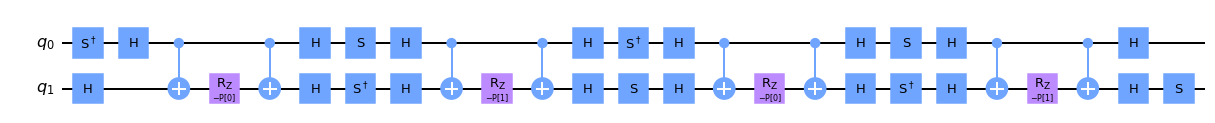

In [27]:
#num_sim_q=3
#anz_op_order_by_amp = list(list(zip(*sorted(uccsd.items(), key=lambda x: abs(x[1]))))[0])
#anz_op_order_by_amp.reverse()
#anz = {op:uccsd[op] for op in anz_op_order_by_amp[:5]}
anz = uccsd

ham_red = mol_circ.ham_reduced[num_sim_q]
anz_red = mol_circ.project_anz_terms(anz, num_sim_q)
init_params = np.array([v.imag for v in anz_red.values()])
bounds = np.array([(p-np.pi, p+np.pi) for p in init_params])

qc = mol_circ.build_circuit(anz, num_sim_q)
qc.parameter_bounds = bounds

print('%i-qubit reduced Hamiltonian:'%num_sim_q, ham_red, '\n')
print('%i-qubit reduced Ansatz:'%num_sim_q, anz_red, '\n')
print('Corresponding reduced Ansatz circuit:')
qc.draw(output='mpl')

# Performing the simulation *without* noise

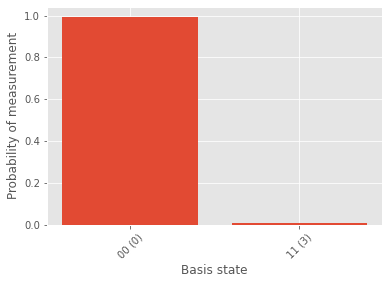

*   Performing 2-qubit CS-VQE over qubit positions 1, 0 ...


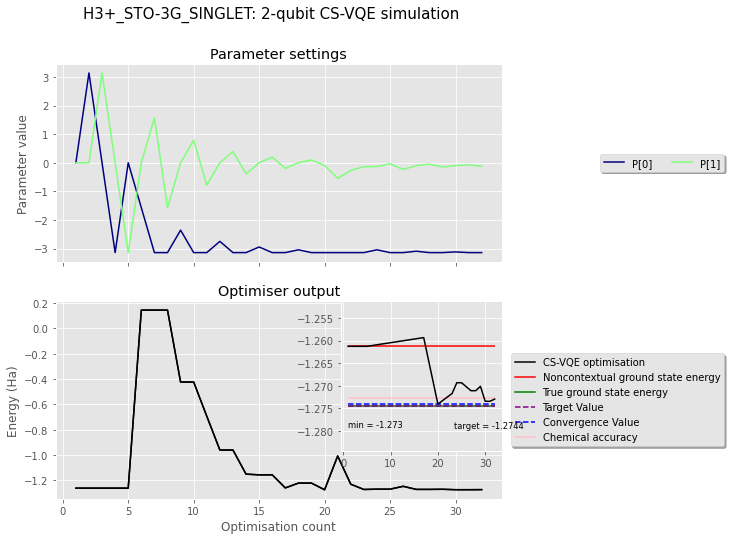

In [30]:
cs_vqe_results = mol_circ.CS_VQE(anz_terms=anz, 
                                 num_sim_q=num_sim_q, 
                                 optimizer=IMFIL(maxiter=10000), 
                                 param_bound=np.pi,
                                 noise=False)

title = '%s: %i-qubit CS-VQE simulation' % (speciesname, num_sim_q)
fig = plot.plot_parameter_settings(cs_vqe_results, title=title)

# Performing the simulation *with* noise

The noise model used below emulates IBM's 5-qubit Vigo device, derived from real-life performance data

In [31]:
import os
from qiskit.algorithms import VQE
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo, FakeTenerife, FakeMelbourne, FakeRueschlikon, FakeTokyo
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter, TensoredMeasFitter

In [32]:
def get_quantum_instance(seed, noise=False, error_mitigation=None):
    algorithm_globals.random_seed = seed
    
    if not noise:
        backend = Aer.get_backend('statevector_simulator')
        qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
    
    else:
        device_backend = FakeRueschlikon()
        backend = Aer.get_backend('aer_simulator')
        noise_model = None
        device = QasmSimulator.from_backend(device_backend)
        coupling_map = device.configuration().coupling_map
        noise_model = NoiseModel.from_backend(device)
        basis_gates = noise_model.basis_gates
        
        qi = QuantumInstance(backend=backend,
                             shots=2**11,
                             seed_simulator=seed, 
                             seed_transpiler=seed,
                             coupling_map=coupling_map, 
                             noise_model=noise_model,
                             measurement_error_mitigation_cls=error_mitigation,
                             measurement_error_mitigation_shots=2**13,
                             cals_matrix_refresh_period=30)
        
    return qi

In [33]:
def vqe_simulation(ansatz, operator, init_params, noise=False, error_mitigation=None):
    
    def store_intermediate_result(eval_count, parameters, mean, std):
        """ Outputs intermediate data during VQE routine
        """
        counts.append(eval_count)
        prmset.append(parameters)
        values.append(mean)
        errors.append(std)
    
    counts=[]
    prmset=[]
    values=[]
    errors=[]
    
    qi = get_quantum_instance(seed=42, noise=noise, error_mitigation=error_mitigation)
    vqe = VQE(ansatz, 
              initial_point=init_params, 
              optimizer=IMFIL(maxiter=1000), 
              callback=store_intermediate_result, 
              quantum_instance=qi) 
    vqe_input_op = qonvert.dict_to_WeightedPauliOperator(operator)
    vqe_run = vqe.compute_minimum_eigenvalue(operator=vqe_input_op)
    
    return {'conval':vqe_run.optimal_value,
            'counts':counts,
            'prmset':prmset,
            'values':values,
            'errors':errors}

Noiseless VQE error: 0.00035528924081162927
Noisy VQE error: -0.0023034041955021234
Noisy VQE with error mitigation error: -0.002303409131070522


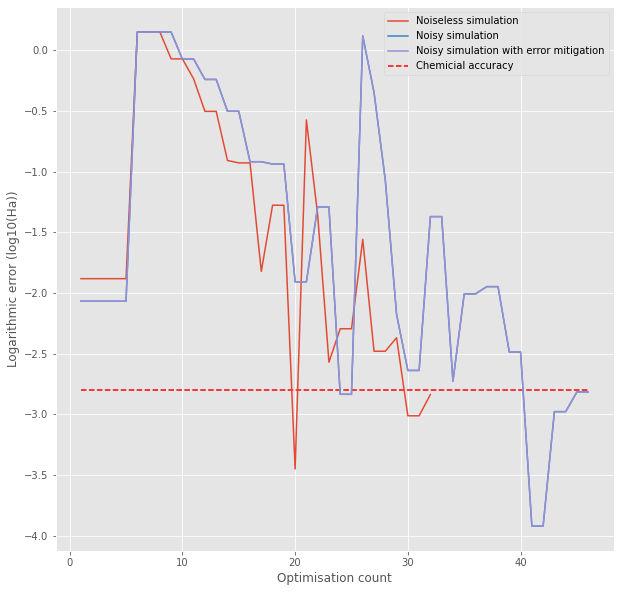

In [34]:
noiseless        = vqe_simulation(ansatz=qc, 
                                  operator=ham_red, 
                                  init_params=init_params, 
                                  noise=False, 
                                  error_mitigation=None)
print('Noiseless VQE error:', noiseless['conval']-mol_circ.true_gs)

noisy            = vqe_simulation(ansatz=qc, 
                                operator=ham_red, 
                                init_params=init_params, 
                                noise=True, 
                                error_mitigation=None)
print('Noisy VQE error:', noisy['conval']-mol_circ.true_gs)

noisy_mitigation = vqe_simulation(ansatz=qc, 
                                operator=ham_red, 
                                init_params=init_params, 
                                noise=True, 
                                error_mitigation=CompleteMeasFitter)#TensoredMeasFitter)
print('Noisy VQE with error mitigation error:', noisy_mitigation['conval']-mol_circ.true_gs)

x_lim = max([noiseless['counts'][-1], noisy['counts'][-1], noisy_mitigation['counts'][-1]])

fig, ax = plt.subplots(figsize=(10,10))

#ax.hlines(mol_circ.true_gs, 1, x_lim, color='g', label='True ground state energy', ls='--')
#ax.hlines(mol_circ.true_gs+0.0016, 1, x_lim, color='pink', label='Chemical accuracy', ls='--')
#ax.hlines(mol_circ.gs_noncon_energy, 1, x_lim, color='red', label='Noncon gs energy', ls='--')
ax.hlines(np.log10(0.0016), 1, x_lim, color='red', label='Chemicial accuracy', ls='--')

ax.plot(noiseless['counts'], [np.log10(abs(v-mol_circ.true_gs)) for v in noiseless['values']], label='Noiseless simulation')
ax.plot(noisy['counts'], [np.log10(abs(v-mol_circ.true_gs)) for v in noisy['values']], label='Noisy simulation')
ax.plot(noisy_mitigation['counts'], [np.log10(abs(v-mol_circ.true_gs)) for v in noisy_mitigation['values']], label='Noisy simulation with error mitigation')

ax.set_xlabel('Optimisation count')
ax.set_ylabel('Logarithmic error (log10(Ha))')
ax.legend()

In [35]:
from qiskit import IBMQ

with open('data/token.txt', 'r') as file:
    TOKEN = file.read()

IBMQ.save_account(TOKEN, overwrite=True)

In [11]:
IBMQ.load_account()

/home/ucaptwe/anaconda3/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/ucaptwe/anaconda3/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/ucaptwe/anaconda3/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/ucaptwe/anaconda3/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [36]:
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_manila')

In [41]:
backend.name()

'ibmq_manila'

In [42]:
from qiskit_nature.runtime import VQEProgram

In [43]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

In [44]:
# currently the VQEProgram supports only 'SPSA' and 'QN-SPSA'
optimizer = {
    'name': 'QN-SPSA',  # leverage the Quantum Natural SPSA
    # 'name': 'SPSA',  # set to ordinary SPSA
    'maxiter': 200,
    'resamplings': {1: 200},  # 100 samples of the QFI for the first step, then 1 sample per step
}

runtime_vqe = VQEProgram(ansatz=qc,
                         optimizer=optimizer,
                         initial_point=init_params,
                         provider=provider,
                         backend=backend,
                         shots=2048,
                         measurement_error_mitigation=True,
                         callback=callback)  # use a complete measurement fitter for error mitigation

In [45]:
vqe_input_op = qonvert.dict_to_WeightedPauliOperator(ham_red)
runtime_result = runtime_vqe.compute_minimum_eigenvalue(vqe_input_op)

/home/ucaptwe/anaconda3/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(


In [46]:
runtime_result.eigenvalue

(-1.156190183519045+0j)

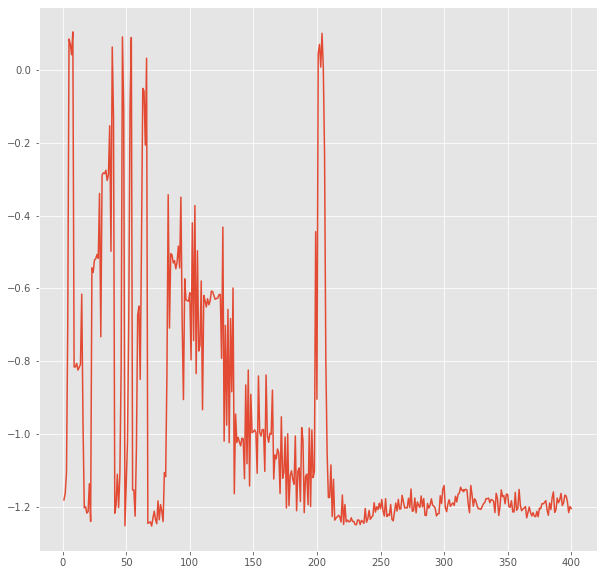

In [47]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(intermediate_info['nfev'], intermediate_info['energy'])

In [48]:
#import json 

#data={}
#for k in intermediate_info.keys():
#    data[str(k)] = intermediate_info[k]

#data['parameters'] = [list(t) for t in data['parameters']]
#data['stddev'] = [t.real for t in data['stddev']]

#with open("data/IBMQ-runtime/"+speciesname+"_UCCSD_taper_CS-VQE_convergence_projected_ansatz.json", "w") as outfile: 
#    json.dump(data, outfile)

In [49]:
#intermediate_info['nfev'] = list(range(len(runtime_result.optimizer_history['loss'])))
#intermediate_info['energy'] = runtime_result.optimizer_history['loss']
#intermediate_info['parameters'] = runtime_result.optimizer_history['params']

parameters={}
for index, param in enumerate([p.name for p in list(qc.parameters)]):
    parameters[param] = list(zip(*intermediate_info['parameters']))[index]
    
data={'counts':intermediate_info['nfev'],
      'values':intermediate_info['energy'],
      'params':parameters,
      'errors':[t.real for t in intermediate_info['stddev']],
      'true_gs':mol_circ.true_gs,
      'result':runtime_result.optimal_value,
      'target':mol_circ.cs_vqe_energy[num_sim_q],
      'gs_noncon_energy':mol_circ.gs_noncon_energy,
      'optimiser':optimizer['name'],
      'backend':backend.name()}

In [50]:
#import json 

#with open("data/IBMQ-runtime/"+speciesname+"_UCCSD_taper_CS-VQE_convergence_projected_ansatz.json", "w") as outfile: 
#    json.dump(data, outfile)

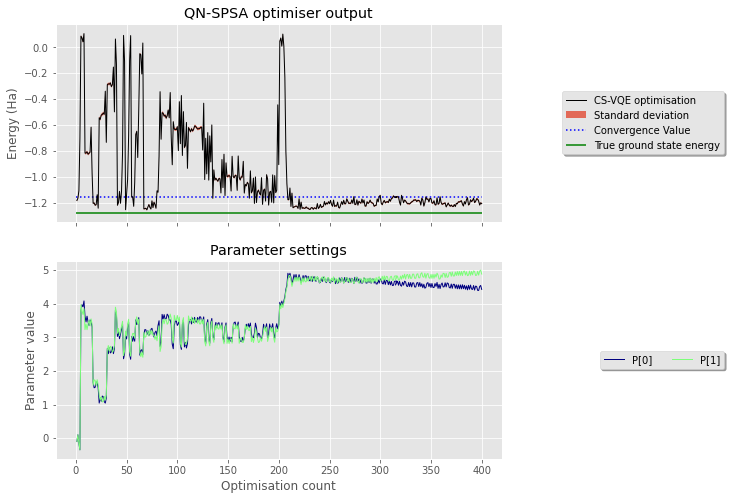

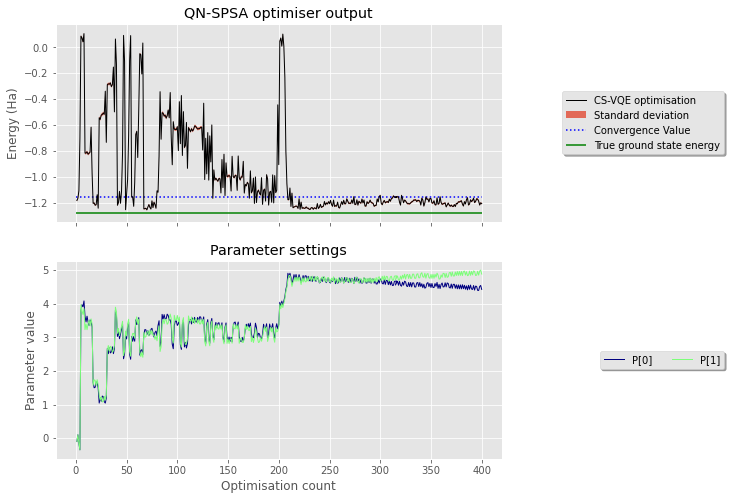

In [51]:
plot.plot_parameter_settings_alt(data)